In [3]:
import torch
import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available
from controlnet_dataset_stroke_input import FridaControlNetDataset
from accelerate import Accelerator
import matplotlib.pyplot as plt
import numpy as np

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2023-05-23 15:41:46.422715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 15:41:46.554091: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-23 15:41:47.072239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynami

In [6]:
pretrained_model_name_or_path = 'runwayml/stable-diffusion-v1-5'
output_dir = './lora_models'
revision = None
mixed_precision="fp16"
seed = 1337

In [7]:
weight_dtype = torch.float16
device = 'cuda'

print('pretrained model', pretrained_model_name_or_path)

# create pipeline
pipeline = DiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path, revision=revision, torch_dtype=weight_dtype,
    safety_checker=None
)
pipeline = pipeline.to(device)

# load attention processors
pipeline.unet.load_attn_procs(output_dir)

pipeline.set_progress_bar_config(disable=True)

# run inference
generator = torch.Generator(device=device).manual_seed(seed)

pretrained model runwayml/stable-diffusion-v1-5


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


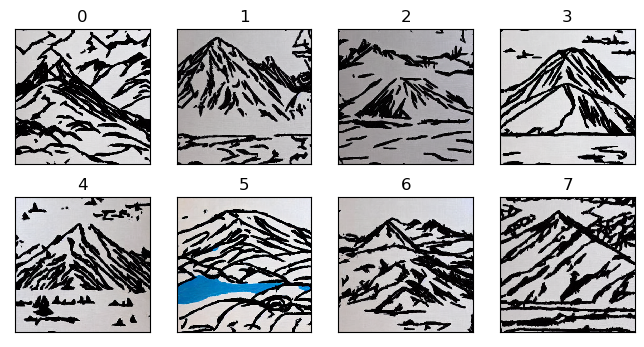

In [19]:
prompt = "A mountain with a ski lift"
n_images = 8
n_cols = 4
n_rows = int(np.ceil(n_images/n_cols))

images = pipeline(prompt, num_inference_steps=30, 
         generator=generator, num_images_per_prompt=n_images).images
fig, ax = plt.subplots(n_rows,n_cols, figsize=(2*n_cols,2*n_rows))
for i in range(n_images):
    ax[int(np.floor(i/n_cols)),i%n_cols].imshow(images[i])
    ax[int(np.floor(i/n_cols)),i%n_cols].set_xticks([])
    ax[int(np.floor(i/n_cols)),i%n_cols].set_yticks([])
    ax[int(np.floor(i/n_cols)),i%n_cols].set_title(str(i))
plt.show()

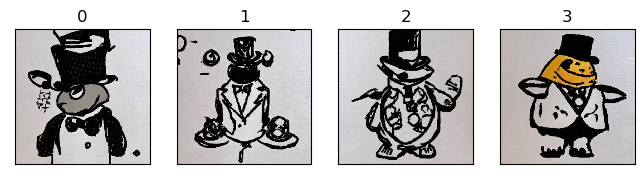

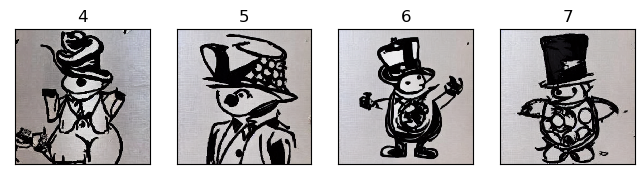

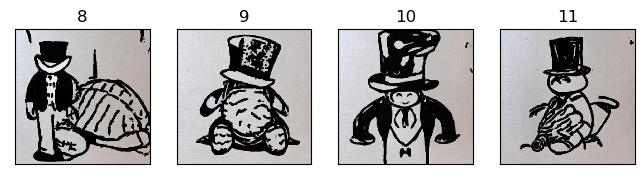

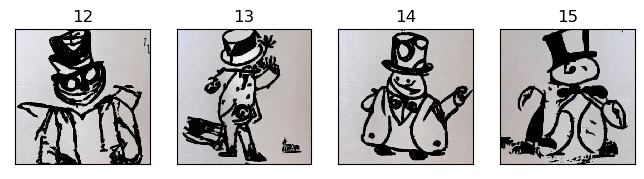

In [22]:
prompt = "A fancy tortoise wearing a top hat and a tuxedo"
n_images = 16
n_cols = 4
n_rows = int(np.ceil(n_images/n_cols))

c = 0
all_images = []
for i in range(int(n_images/n_cols)):
    
    images = pipeline(prompt, num_inference_steps=30, 
             generator=generator, num_images_per_prompt=n_cols).images
    fig, ax = plt.subplots(1,n_cols, figsize=(2*n_cols,2))
    for j in range(n_cols):
        ax[j].imshow(images[j])
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].set_title(str(c))
        c += 1
    all_images += images
    plt.show()

In [53]:
chosen_img_id = 5
img_fn = 'paint_this_img.jpg'
images[chosen_img_id].save(img_fn)

!python3 plan.py --use_cache \
        --cache_dir caches/cache_6_6/ \
        --ink \
        --num_strokes 100 \
        --objective clip_conv_loss --objective_data $img_fn --objective_weight 1.0 \
        --lr_multiplier 1.0 \
        --optim_iter 500 \
        --paint_from_image

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Must specify --brush_length cmd line param. Measure the brush length.
Must specify --brush_length cmd line param. Measure the brush length.
2023-05-23 13:48:03.435880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 13:48:03.507817: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ON

In [57]:

!python3 plan.py --use_cache \
        --cache_dir caches/cache_6_6/ \
        --ink \
        --num_strokes 100 \
        --objective clip_conv_loss text --objective_data $img_fn $prompt \
        --objective_weight 1.0 2.0 \
        --lr_multiplier 1.0 \
        --optim_iter 1000 \
        --n_inits 0

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Must specify --brush_length cmd line param. Measure the brush length.
Must specify --brush_length cmd line param. Measure the brush length.
2023-05-23 14:00:27.242503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 14:00:27.314686: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ON